In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [35]:
associations_df = pd.read_csv("config/associations_df.csv")
associations_df = associations_df.drop(columns=["Unnamed: 0"])
lp_schedule = pd.read_csv("schedules/linear_programming_green.csv")
lp_schedule = lp_schedule.drop(columns=['idx'])
brute_force_schedule = pd.read_csv("schedules/green_schedule.csv")
brute_force_schedule = brute_force_schedule.drop(columns=['idx'])
worst_case_schedule = pd.read_csv("schedules/worst_case_schedule.csv")
worst_case_schedule = worst_case_schedule.drop(columns=['idx'])
basic_schedule = pd.read_csv("schedules/basic_planner.csv")
print(associations_df.columns)

Index(['node', 'job_id', 'forecast_id', 'transfer_time', 'throughput',
       'host_joules', 'link_joules', 'total_joules', 'avg_ci',
       'carbon_emissions'],
      dtype='object')


In [36]:
def visualize_schedule(schedule_df, associations_df, name):
    # Get unique nodes and time slots (forecast_id)
    nodes = associations_df['node'].unique()
    time_slots = range(24)  # 0 to 23 (24-hour period)

    # Create a grid of all nodes and time slots
    grid_df = pd.DataFrame([(node, t) for node in nodes for t in time_slots], columns=['node', 'forecast_id'])

    # Merge with schedule_df to get job assignments
    grid_df = grid_df.merge(
        schedule_df[['node', 'forecast_id', 'job_id', 'carbon_emissions']],
        on=['node', 'forecast_id'],
        how='left'
    )

    # Fill NaN job_id with -1 (no job scheduled) and NaN carbon_emissions with 0
    grid_df['job_id'] = grid_df['job_id'].fillna(-1)
    grid_df['carbon_emissions'] = grid_df['carbon_emissions'].fillna(0)

    # Aggregate data for each node and forecast_id
    aggregated_df = grid_df.groupby(['node', 'forecast_id'], as_index=False).agg({
        'job_id': lambda x: ', '.join(map(str, x[x != -1])),  # Combine job_ids
        'carbon_emissions': 'sum'  # Sum carbon_emissions
    })

    # Fill empty job_id combinations with '-1'
    aggregated_df['job_id'] = aggregated_df['job_id'].replace('', '-1')

    # Pivot the grid to create a heatmap-friendly format
    heatmap_data = aggregated_df.pivot(index='node', columns='forecast_id', values='carbon_emissions')
    job_data = aggregated_df.pivot(index='node', columns='forecast_id', values='job_id')

    # Define a color map for carbon emissions (green to red)
    cmap = mcolors.LinearSegmentedColormap.from_list("emissions_cmap", ["green", "yellow", "red"])
    norm = mcolors.Normalize(vmin=associations_df['carbon_emissions'].min(),
                             vmax=associations_df['carbon_emissions'].max())

    # Plot the heatmap
    plt.figure(figsize=(15, 6))
    sns.heatmap(
        heatmap_data,
        cmap=cmap,  # Color map for carbon emissions
        norm=norm,  # Normalize emissions values
        annot=job_data,  # Show job IDs in cells
        fmt="",  # No special formatting for annotations
        cbar_kws={'label': 'Carbon Emissions'},
        linewidths=0.5,
        linecolor='black',
        mask=(job_data == '-1')  # Mask empty slots
    )

    # Customize the plot
    plt.xlabel('Forecast ID (Time Slot)')
    plt.ylabel('Node')
    plt.title(f'Job Schedule Heatmap (24-Hour Period) - Colored by Carbon Emissions using {name}')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

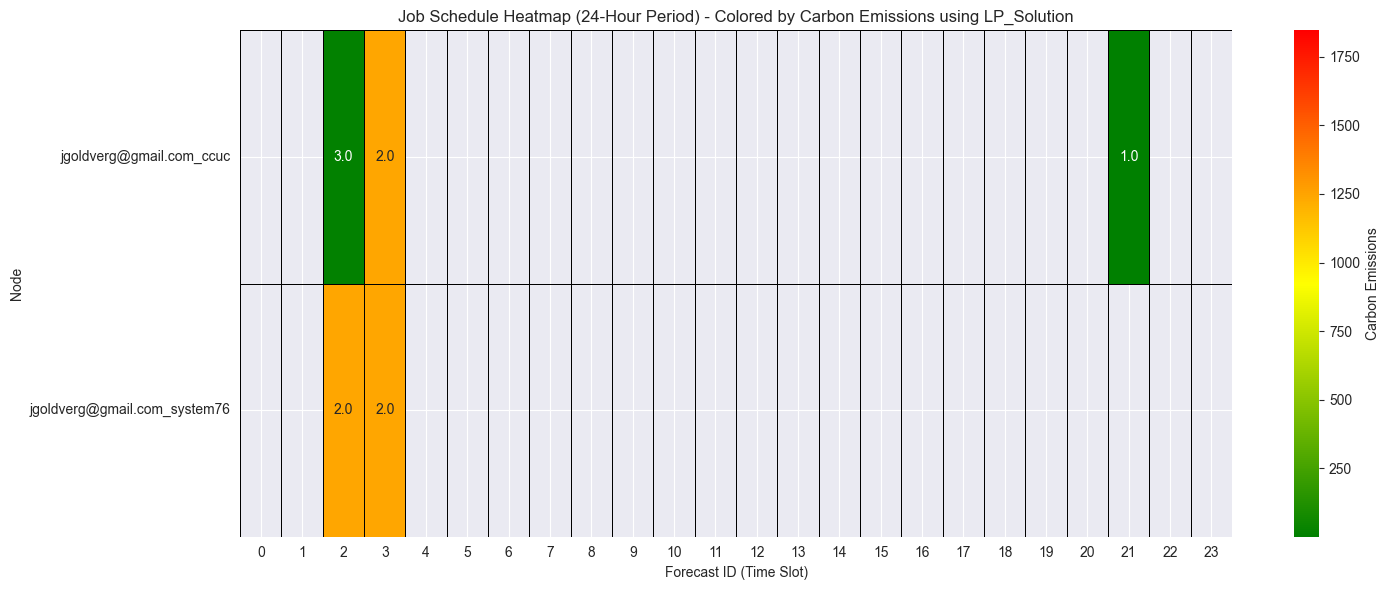

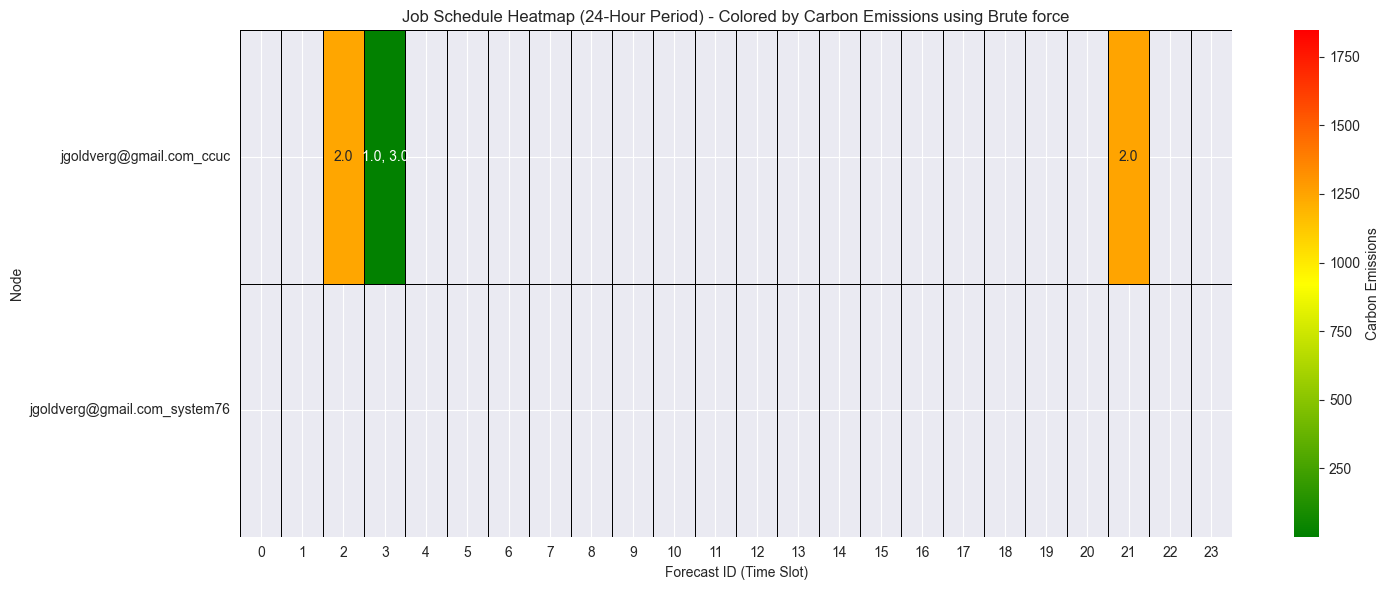

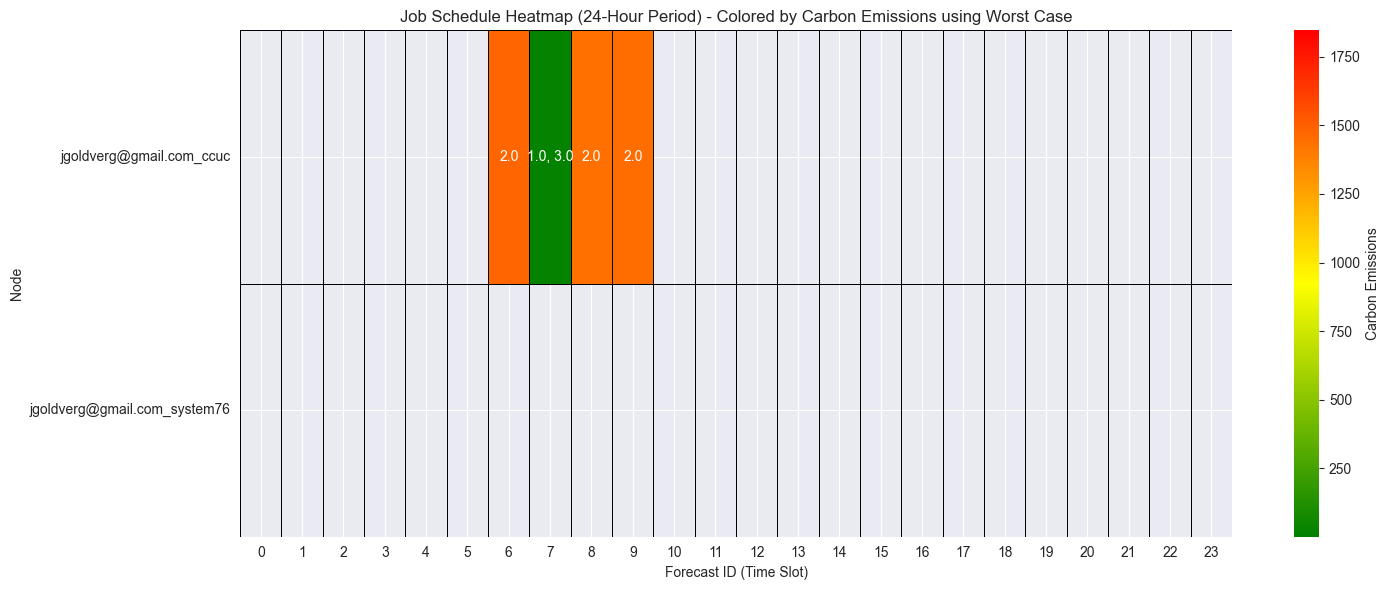

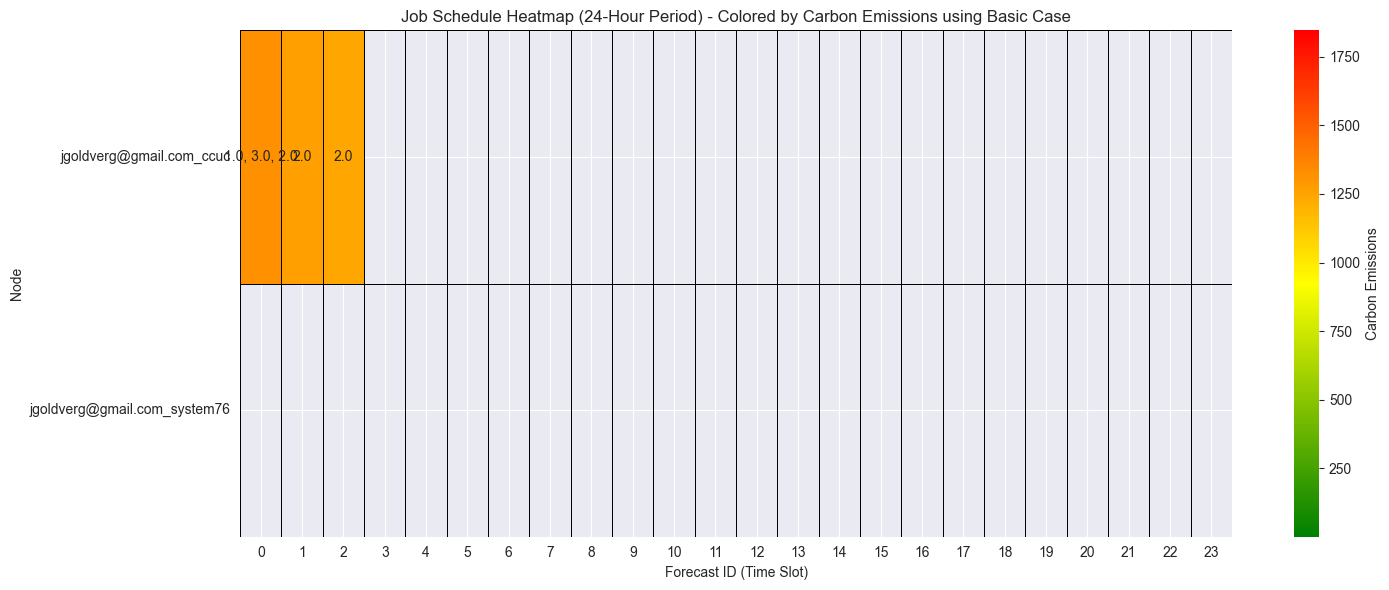

In [37]:
visualize_schedule(lp_schedule, associations_df, "LP_Solution")
visualize_schedule(brute_force_schedule, associations_df, "Brute force")
visualize_schedule(worst_case_schedule, associations_df, "Worst Case")
visualize_schedule(basic_schedule, associations_df, "Basic Case")

In [38]:
def total_emissions_schedule(schedule_df, schedule_name):
    print(f"{schedule_name} created a total emissions of {schedule_df['carbon_emissions'].sum()}")

total_emissions_schedule(lp_schedule, "Linear Programming")
total_emissions_schedule(brute_force_schedule, "Brute Force")
total_emissions_schedule(worst_case_schedule, "Worst Case")
total_emissions_schedule(basic_schedule, "Basic Case")

Linear Programming created a total emissions of 3741.8663962222226
Brute Force created a total emissions of 3761.5967122777784
Worst Case created a total emissions of 4375.20010738889
Basic Case created a total emissions of 3831.3426620555556
